# Named Entity Recognition (NER)

Hello, 

First of all, I thank you for taking your time out for us. This notebook contains all our learnings, understanding and how we interpret the language model. We will be trying everything we know, somethgings we don't know but it worked and tring to figure out why it worked!

We will ensure, or atleast try to explain all the libraries and approaches that we have used but was not part of the session.

Please bear with us as you watch us grow and reach new levels.

Thank you!

## Problem Statement

### Information Extraction From Scientific Publication

Named Entity Recognition (NER) is one of the most popular applications of Natural Language Processing. For the scope of this project, we will focus on creating a NER model that identifies key tokens and classifies them into set of predefined entities.

The number of scientific papers published per year has exploded in recent years, strengthening its value as one of the main drivers for scientific progress. In astronomy alone, more than 41,000 new articles are published every year and the vast majority are available either via an open-access model or via pre-print services. Indexing the article’s full-text in search engines helps discover and retrieve vital scientific information to continue building on the shoulders of giants, informing policy, and making evidence-based decisions. Nevertheless, it is difficult to navigate in this ocean of data; finding articles rely heavily on string matching searches and following citations/references. NER helps us extract key information from scientific papers which can help search engines to better select and filter articles.

For this, we will first train a language model on WIESP dataset. We will define and train a simple RNN network with 2 RNN layers as our baseline model. Then we will play around with BiLSTMs, Time Distributed Layers and much more.

In [ ]:
# Importing all the necessary packages

import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from shutil import copyfile
from imutils import paths
from PIL import Image
import requests
import re
import json
import zipfile
import collections
import urllib.request
from collections import defaultdict
from IPython.core.display import HTML
import time
import random
import string

# Imports for dataset separation
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, RNN, GRUCell, Dropout, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Tensorflow imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model

%matplotlib inline

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.8.2
keras version 2.8.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# After trying a few dozen approached to parse those json file, and failing miserably
# we came to realize let's not just stick on the path that has been shown. We are aiming to
# be a data scientist and what type of scientiests back aways from experimenting!
# Well with that said, if things don't work, do from scratch! No shortcuts...

# !pip install datasets
# # Make sure that we have a recent version of pyarrow in the session before we continue - otherwise reboot Colab to activate it
# import pyarrow
# if int(pyarrow.__version__.split('.')[1]) < 16 and int(pyarrow.__version__.split('.')[0]) == 0:
#     import os
#     os.kill(os.getpid(), 9)

# from datasets import list_datasets, list_metrics, load_dataset, load_metric
# from pprint import pprint

# datasets_list = list_datasets()
# metrics_list = list_metrics()

In [ ]:
# This is hugging face showing off it's content:
# Currently 5673 datasets are available on the hub.

#@@@@@@@@@@@@@@@@@@@
#@@@@@@@@@@@@@@@@@@@
#@@@@@@@@@@@@@@@@@@@     Uncomment code below and run, but it's a really long list so suit yourself! 
#@@@@@@@@@@@@@@@@@@@
#@@@@@@@@@@@@@@@@@@@

# print(f" Currently {len(datasets)} datasets are available on the hub:")
# pprint(datasets, compact=True)
# print(f" Currently {len(metrics)} metrics are available on the hub:")
# pprint(metrics, compact=True)

# Let's take a look at the dataset attributes
# WIESP2022NER_dataset = list_datasets(with_details=True)[datasets.index('fgrezes/WIESP2022-NER')]
# WIESP2022NER_dataset.__dict__

We will load the NER Training , NER DEV, NER Validation and NER_TAGS files which are in json form

In [ ]:
# Loading the DEV dataset
import json
with open("/content/WIESP2022-NER-DEV.jsonl", 'r') as f:
    wiesp_dev_json = [json.loads(l) for l in list(f)]

In [ ]:
# Loading the training dataset
with open("/content/WIESP2022-NER-TRAINING.jsonl", 'r') as f:
    wiesp_train_json = [json.loads(l) for l in list(f)]

In [ ]:
# Loading the validation dataset
with open("/content/WIESP2022-NER-VALIDATION-NO-LABELS.jsonl", 'r') as f:
    wiesp_validation_json = [json.loads(l) for l in list(f)]

In [ ]:
# loading NER Tags
with open('/content/ner_tags.json') as json_file:
    tag_dict = json.load(json_file)

tag_dict

{'B-Archive': 0,
 'B-CelestialObject': 1,
 'B-CelestialObjectRegion': 2,
 'B-CelestialRegion': 3,
 'B-Citation': 4,
 'B-Collaboration': 5,
 'B-ComputingFacility': 6,
 'B-Database': 7,
 'B-Dataset': 8,
 'B-EntityOfFutureInterest': 9,
 'B-Event': 10,
 'B-Fellowship': 11,
 'B-Formula': 12,
 'B-Grant': 13,
 'B-Identifier': 14,
 'B-Instrument': 15,
 'B-Location': 16,
 'B-Mission': 17,
 'B-Model': 18,
 'B-ObservationalTechniques': 19,
 'B-Observatory': 20,
 'B-Organization': 21,
 'B-Person': 22,
 'B-Proposal': 23,
 'B-Software': 24,
 'B-Survey': 25,
 'B-Tag': 26,
 'B-Telescope': 27,
 'B-TextGarbage': 28,
 'B-URL': 29,
 'B-Wavelength': 30,
 'I-Archive': 31,
 'I-CelestialObject': 32,
 'I-CelestialObjectRegion': 33,
 'I-CelestialRegion': 34,
 'I-Citation': 35,
 'I-Collaboration': 36,
 'I-ComputingFacility': 37,
 'I-Database': 38,
 'I-Dataset': 39,
 'I-EntityOfFutureInterest': 40,
 'I-Event': 41,
 'I-Fellowship': 42,
 'I-Formula': 43,
 'I-Grant': 44,
 'I-Identifier': 45,
 'I-Instrument': 46,
 'I

Let's look at the sample data and see 

Each entry consists of a dictionary with the following keys:

"unique_id": a unique identifier for this data sample. Must be included in the predictions.

"tokens": the list of tokens (strings) that form the text of this sample. Must be included in the predictions.

"ner_tags": the list of NER tags (in IOB2 format)

ow to compute your scores on the training data:

1. format your predictions as a list of dictionaries, each with the same "unique_id" and "tokens" keys from the dataset, as well as the list of predicted NER tags under the "pred_ner_tags" key (see WIESP2022-NER-DEV-sample-predictions.jsonl for an example).

2. pass the references and predictions datasets to the compute_MCC() and compute_seqeval() functions (from the .py files with the same names).


In [ ]:
df_DEV = pd.DataFrame(wiesp_dev_json)
df_DEV.drop(columns=["bibcode",	"label_studio_id",	"ner_ids"], inplace=True)
df_DEV.head(3)

,ner_tags,section,tokens,unique_id
0,"[O, O, O, O, O, O, O, B-Instrument, O, O, O, O...",fulltext,"[Whilst, a, reasonable, harmonic, fit, to, the...",fulltext_487_2019MNRAS.486.5558S
1,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",acknowledgments,"[ACKNOWLEDGEMENTS, The, authors, thank, an, an...",acknowledgments_1086_2018MNRAS.480.3062L
2,"[O, O, O, B-Person, I-Person, B-Person, I-Pers...",acknowledgments,"[ACKNOWLEDGEMENTS, We, thank, Dougal, Mackey,,...",acknowledgments_559_2019MNRAS.482L...9B


We did some exploration if number of tags are matching the tokens.

In [ ]:
len(df_DEV.iloc[0].ner_tags),len(df_DEV.iloc[0].tokens)

(536, 536)

In [ ]:
len(df_DEV.iloc[1].ner_tags),len(df_DEV.iloc[1].tokens)

(50, 50)

In [ ]:
len(df_DEV.iloc[2].ner_tags),len(df_DEV.iloc[2].tokens)

(119, 119)

In [ ]:
len(wiesp_dev_json),len(wiesp_train_json)

(20, 1753)

Let's look at how the tokens and NER_Tags look

In [ ]:
df_DEV.iloc[0].ner_tags[7],df_DEV.iloc[0].tokens[7]

('B-Instrument', 'ESPaDOnS')

In [ ]:
df_DEV.iloc[1].ner_tags[0],df_DEV.iloc[1].tokens[0]

('O', 'ACKNOWLEDGEMENTS')

In [ ]:
df_DEV.iloc[1].ner_tags[15],df_DEV.iloc[1].tokens[15]

('B-Person', 'NWCL')

In [ ]:
df_DEV.iloc[2].ner_tags[3],df_DEV.iloc[2].tokens[3]

('B-Person', 'Dougal')

In [ ]:
df_DEV.iloc[2].ner_tags[4],df_DEV.iloc[2].tokens[4]

('I-Person', 'Mackey,')

In [ ]:
df_DEV.iloc[2].ner_tags[5],df_DEV.iloc[2].tokens[5]

('B-Person', 'Adrian')

O ---> Outside of a named entity

B-MIS ---> Beginning of a miscellaneous entity right after another miscellaneous entity

I-MIS ---> Miscellaneous entity

B-PER ---> Beginning of a person’s name right after another person’s name

I-PER ---> Person’s name

B-ORG ---> Beginning of an organisation right after another organisation

I-ORG ---> Organisation

B-LOC ---> Beginning of a location right after another location

I-LOC ---> Location

Let's load NER_tags, and look at all the tags availbale.

In [ ]:
print("Number of tags present :",len(tag_dict))

Number of tags present : 63


In [ ]:
df_DEV.head(3)

,ner_tags,section,tokens,unique_id
0,"[O, O, O, O, O, O, O, B-Instrument, O, O, O, O...",fulltext,"[Whilst, a, reasonable, harmonic, fit, to, the...",fulltext_487_2019MNRAS.486.5558S
1,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",acknowledgments,"[ACKNOWLEDGEMENTS, The, authors, thank, an, an...",acknowledgments_1086_2018MNRAS.480.3062L
2,"[O, O, O, B-Person, I-Person, B-Person, I-Pers...",acknowledgments,"[ACKNOWLEDGEMENTS, We, thank, Dougal, Mackey,,...",acknowledgments_559_2019MNRAS.482L...9B



Now let's do the same of the training dataset.
#### Idea 1

tokens ------> sentence


unique_id_1 | section | sentence_1 | token_1_1 | ner_tags_1_1 | ner_tag_dict =>  label

In [ ]:
df_train = pd.DataFrame(wiesp_train_json)
df_train.drop(columns=["bibcode",	"label_studio_id",	"ner_ids"], inplace=True)
df_train.head(3)

,ner_tags,section,tokens,unique_id
0,"[O, O, O, O, O, O, O, B-Instrument, O, O, O, O...",fulltext,"[Whilst, a, reasonable, harmonic, fit, to, the...",fulltext_487_2019MNRAS.486.5558S
1,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",fulltext,"[comparison, once, the, angular, positions, of...",fulltext_1129_2018MNRAS.478.5533F
2,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",acknowledgments,"[ACKNOWLEDGEMENTS, The, authors, thank, an, an...",acknowledgments_1086_2018MNRAS.480.3062L


In [ ]:
ss= []
for i in df_train.ner_tags:
  ss.append(len(i))
print("Maximum length of the sentence present in training dataset is :",max(ss))

Maximum length of the sentence present in training dataset is : 795


In [ ]:
def Average(lst):
    return round(sum(lst) / len(lst))

print("Average length of the sentence present in training dataset is :",Average(ss))

Average length of the sentence present in training dataset is : 327


Finding the average sentence length as, we can not randomly truncate the sentences as most of ner tags are " O's " and they don't help much in training. In addition to it many sentences start with multitude of 'O' only after many number of such 'O's we have important NER tags which give value.

Average sentence lenght is 327 approx, which will be a helpful parameter to select sequence lenght to get more value out of our data at less computational cost.

We will set sequence lenght to 300 Based on the above obervation

In [ ]:
# First we need Vocabulary
vocab = []
for value in df_train.tokens:
  vocab.extend(value)
vocab_main = []
for word in vocab:
  words = word.lower()
  vocab_main.append(words)
tags = []
for tag in df_train.ner_tags:
  tags.append(tag)

In [ ]:
len(vocab_main)

573132

In [ ]:
vocab_main = set(vocab_main)

In [ ]:
len(vocab_main)

45753

In [ ]:
# let's test something for looking at the tokens and predictions later
idx2tok = {(idx+2):tok for  idx, tok in enumerate(vocab_main)}
tok2idx = {tok:(idx+2) for  idx, tok in enumerate(vocab_main)}

In [ ]:
temp = df_train.tokens[0]

In [ ]:
print(temp)

['Whilst', 'a', 'reasonable', 'harmonic', 'fit', 'to', 'the', 'ESPaDOnS', 'data', 'can', 'be', 'achieved', 'using', 'this', 'period,', 'it', 'does', 'not', 'produce', 'an', 'acceptable', 'phasing', 'of', 'all', 'available', '〈', 'B', 'z', '〉', 'measurements.', 'Figure', '1.', 'Photometric', '(', 'top', ')', 'and', 'magnetic', '〈', 'B', 'z', '〉', '(', 'bottom', ')', 'measurements,', 'phased', 'with', 'periods', 'determined', 'from', '(left', 'to', 'right)', 'K2', 'photometry,', 'all', '〈', 'B', 'z', '〉', 'measurements,', 'and', 'all', 'photometric', 'measurements.', '〈', 'B', 'z', '〉', 'measurements', 'were', 'obtained', 'from', 'ESPaDOnS', 'by', 'Shultz', 'et', 'al.', '(', '2018', ')', 'and', 'photopolarimetric', 'data', 'by', 'Borra', 'et', 'al.', '(', '1983', ',', 'BLT83)', 'and', 'Bohlender', 'et', 'al.', '(', '1993', ',', 'BLT93).', 'The', 'solid', 'and', 'dashed', 'curves', 'show,', 'respectively,', 'the', 'best', 'second-order', 'harmonic', 'fit', 'to', 'the', 'ESPaDOnS', '〈', 'B

In [ ]:
temp2 = [*map(tok2idx.get, temp)]

In [ ]:
print(temp2)

[None, 20531, 25093, 392, 10744, 10404, 36208, None, 11313, 36986, 29363, 14366, 8239, 5382, 15213, 15243, 10728, 634, 21472, 26138, 26464, 38809, 42018, 32792, 37997, 42948, None, 29546, 31020, 21954, None, 22900, None, 45287, 33319, 41697, 15433, 37208, 42948, None, 29546, 31020, 45287, 5206, 41697, 2684, 15985, 41985, 20980, 5844, 3095, 2671, 10404, 12082, None, 16114, 32792, 42948, None, 29546, 31020, 2684, 15433, 32792, 42708, 21954, 42948, None, 29546, 31020, 13353, 19179, 25248, 3095, None, 6007, None, 13686, 35891, 45287, 15758, 41697, 15433, 14511, 11313, 6007, None, 13686, 35891, 45287, 37133, 12275, None, 15433, None, 13686, 35891, 45287, 2668, 12275, None, None, 24510, 15433, 14685, 20022, 43787, 20513, 36208, 20282, 9239, 392, 10744, 10404, 36208, None, 42948, None, 29546, 31020, 11313, 15433, 36208, 30943, 10744, 39842, None, 11313, 5135, 3095, None, None, None, 45287, None, 24224, 12227, 15433, None, 33478, 12440, 43691, 6007, None, 13686, 35891, 45287, 19565, 12275, Non

In [ ]:
idx2tok[2]

'superwasp'

In [ ]:
d = df_train.tokens
t = df_train.ner_tags

In [ ]:
print(*d[0], sep=', ')
print(*t[0], sep=', ')

Whilst, a, reasonable, harmonic, fit, to, the, ESPaDOnS, data, can, be, achieved, using, this, period,, it, does, not, produce, an, acceptable, phasing, of, all, available, 〈, B, z, 〉, measurements., Figure, 1., Photometric, (, top, ), and, magnetic, 〈, B, z, 〉, (, bottom, ), measurements,, phased, with, periods, determined, from, (left, to, right), K2, photometry,, all, 〈, B, z, 〉, measurements,, and, all, photometric, measurements., 〈, B, z, 〉, measurements, were, obtained, from, ESPaDOnS, by, Shultz, et, al., (, 2018, ), and, photopolarimetric, data, by, Borra, et, al., (, 1983, ,, BLT83), and, Bohlender, et, al., (, 1993, ,, BLT93)., The, solid, and, dashed, curves, show,, respectively,, the, best, second-order, harmonic, fit, to, the, ESPaDOnS, 〈, B, z, 〉, data, and, the, 1σ, fit, uncertainty., Photometric, data, are, from, K2,, SMEI,, Hipparcos, (, H, p, ),, and, Strömgren, y, photometry, published, by, Sterken, et, al., (, 1995, ,, S95),, Manfroid, et, al., (, 1995, ,, M95),, an

In [ ]:
print(*d[1], sep=', ')
print(*t[1], sep=', ')

comparison, once, the, angular, positions, of, the, satellites, are, randomized, around, this, point., From, this, tensor, we, compute, its, eigenvalues,, λ, 1, >, λ, 2, >, λ, 3, ,, and, corresponding, eigenvectors,, ,, ,, ., We, define, the, size, of, the, three, ellipsoidal, axis, as, a, =, λ, 1, ,, b, =, λ, 2, ,, and, c, =, λ, 3, ., We, also, define, as, the, vector, perpendicular, to, the, planar, satellite, distribution., We, also, define, the, RMS, plane, width, w, as, the, standard, deviation, of, the, satellite, distances, to, the, plane, defined, by, the, vector, ., To, summarize, we, characterize, the, satellite, distributionwith, the, following, quantities, obtained, from, the, inertia, tensor:, RMS, plane, width,, w, ., c, /, a, axis, ratio., b, /, a, axis, ratio., 3.3, Characterizing, asphericity, with, normalized, scalars, We, compare, each, satellite, distribution, against, its, own, spherically, randomized, distribution., We, keep, fixed, the, radial, position, of, ever

In [ ]:
print(*d[2], sep=', ')
print(*t[2], sep=', ')

ACKNOWLEDGEMENTS, The, authors, thank, an, anonymous, reviewer, for, comments, and, suggestions, that, strengthened, our, manuscript., NWCL, gratefully, acknowledges, support, from, the, American, Museum, of, Natural, History, and, the, Richard, Guilder, Graduate, School,, specifically, the, Kalbfleisch, Fellowship, Program,, as, well, as, support, from, a, National, Science, Foundation, Award, No., AST, 11-09395.
O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-Person, O, O, O, O, O, B-Organization, I-Organization, I-Organization, I-Organization, I-Organization, O, O, B-Organization, I-Organization, I-Organization, I-Organization, O, O, B-Fellowship, I-Fellowship, I-Fellowship, O, O, O, O, O, O, B-Organization, I-Organization, I-Organization, O, O, B-Grant, I-Grant


In [ ]:
print(*d[3], sep=', ')
print(*t[3], sep=', ')

BDM, gratefully, acknowledges, support, from, NASA, Fermi, grant, NNX14AQ68G,, NSF, grant, AST-1410950,, and, the, Alfred, P., Sloan, Foundation., We, thank, the, anonymous, reviewer, for, several, helpful, suggestions, and, for, emphasizing, the, applicability, of, our, results, to, Type, IIn, supernovae.
B-Person, O, O, O, O, B-Organization, B-Grant, I-Grant, I-Grant, B-Organization, O, B-Grant, O, O, B-Organization, I-Organization, I-Organization, I-Organization, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O


In [ ]:
# vocab_clean=[]
# for word in vocab:
#   words = word.lower().translate(str.maketrans('', '', string.punctuation))
#   if len(words)>1:vocab_clean.append(words)  

Removing any words from the tokens will result mismatching of the NER tags associated with the words and will require re-mapping.

**Looking into the data , the columns and the number of unique NER tags and Data Analysis**

In [ ]:
counts = []
for item in tags:
  for j in item:
    counts.append(j) 

**Checking for tags which have maximum words assign to them so we don't miss them during data cleaning as it will affect our Model accuracy**

In [ ]:
from collections import Counter
count_dict = Counter(counts)

In [ ]:
count_dict

Counter({'B-Archive': 192,
         'B-CelestialObject': 2940,
         'B-CelestialObjectRegion': 265,
         'B-CelestialRegion': 158,
         'B-Citation': 6360,
         'B-Collaboration': 306,
         'B-ComputingFacility': 399,
         'B-Database': 256,
         'B-Dataset': 328,
         'B-EntityOfFutureInterest': 61,
         'B-Event': 45,
         'B-Fellowship': 411,
         'B-Formula': 2088,
         'B-Grant': 3478,
         'B-Identifier': 112,
         'B-Instrument': 714,
         'B-Location': 1404,
         'B-Mission': 110,
         'B-Model': 1800,
         'B-ObservationalTechniques': 124,
         'B-Observatory': 873,
         'B-Organization': 7448,
         'B-Person': 3916,
         'B-Proposal': 100,
         'B-Software': 1017,
         'B-Survey': 885,
         'B-Tag': 66,
         'B-Telescope': 1573,
         'B-TextGarbage': 52,
         'B-URL': 294,
         'B-Wavelength': 3384,
         'I-Archive': 466,
         'I-CelestialObject': 1691,


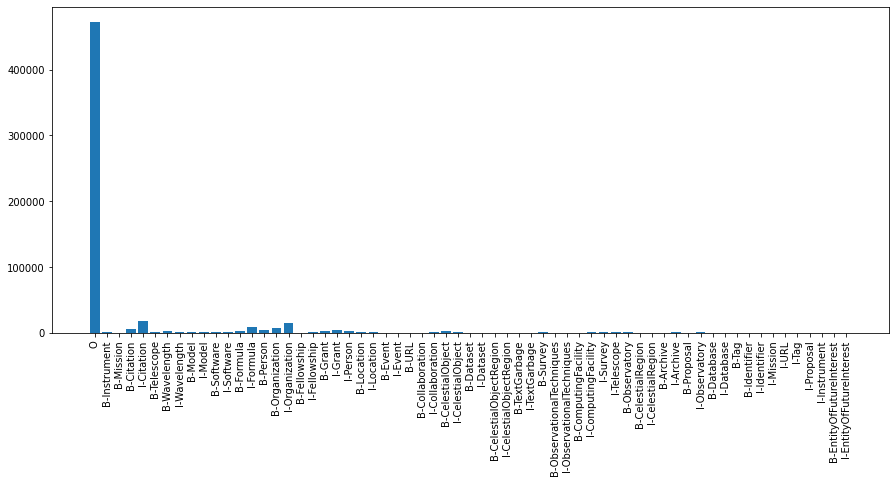

In [ ]:
# Majority of the tokens have "O" as their tag so it skews the result by a lot
data = count_dict
names = list(data.keys())
values = list(data.values())
fig,ax=plt.subplots(figsize=(15,6))
plt.bar(range(len(data)), values, tick_label=names)
plt.xticks(rotation=90)
plt.show()

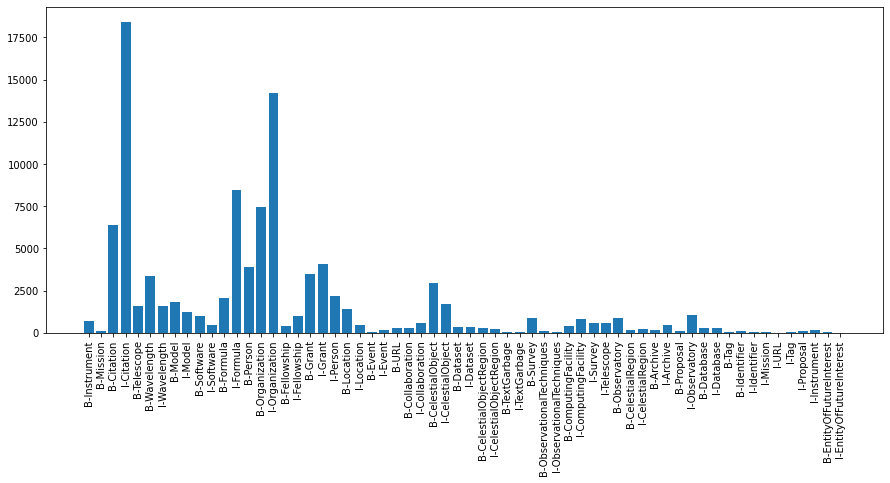

In [ ]:
# After removing 'O' from the dictioanry
del count_dict['O']
data = count_dict
names = list(data.keys())
values = list(data.values())
fig,ax=plt.subplots(figsize=(15,6))
plt.bar(range(len(data)), values, tick_label=names)
plt.xticks(rotation=90)
plt.show()

In [ ]:
Tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=len(vocab_main),
        filters= None,
        lower=True,
        char_level=False,
        oov_token=None)

In [ ]:
Tokenizer.fit_on_texts(df_train.tokens)

In [ ]:
word2idx = Tokenizer.word_index
idx2word = Tokenizer.index_word
vocab_size = Tokenizer.num_words

In [ ]:
#show the 20 first words
for i in range(1,20):
    print(idx2word[i])

the
of
and
in
to
a
for
is
we
by
with
this
from
that
et
al.
are
(
at


Notice How we have ( in our tags, we plan to work with dataset that is cleaner, currently the challenege is that they are all tagged so we will need to map all tokens first with ner_tags. Then clean the tokens and then use the respective tags only.

In [ ]:
df_train.drop(columns=['section','unique_id'],inplace =True)
df_train.head()

,ner_tags,tokens
0,"[O, O, O, O, O, O, O, B-Instrument, O, O, O, O...","[Whilst, a, reasonable, harmonic, fit, to, the..."
1,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[comparison, once, the, angular, positions, of..."
2,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[ACKNOWLEDGEMENTS, The, authors, thank, an, an..."
3,"[B-Person, O, O, O, O, B-Organization, B-Grant...","[BDM, gratefully, acknowledges, support, from,..."
4,"[O, O, O, B-Person, I-Person, B-Person, I-Pers...","[ACKNOWLEDGEMENTS, We, thank, Dougal, Mackey,,..."


In [ ]:
tag_list = []
for element in df_train.ner_tags:
    for i in element:
        if i not in tag_list:
            tag_list.append(i)

In [ ]:
Tokenizer_2 = tf.keras.preprocessing.text.Tokenizer(num_words=len(tag_list))
Tokenizer_2.fit_on_texts(df_train.ner_tags)
word2idx_tag = Tokenizer_2.word_index
idx2word_tag = Tokenizer_2.index_word
vocab_size_tag = Tokenizer_2.num_words
word2idx_tag

{'b-archive': 44,
 'b-celestialobject': 11,
 'b-celestialobjectregion': 39,
 'b-celestialregion': 46,
 'b-citation': 6,
 'b-collaboration': 37,
 'b-computingfacility': 34,
 'b-database': 41,
 'b-dataset': 36,
 'b-entityoffutureinterest': 55,
 'b-event': 59,
 'b-fellowship': 33,
 'b-formula': 13,
 'b-grant': 9,
 'b-identifier': 49,
 'b-instrument': 26,
 'b-location': 18,
 'b-mission': 50,
 'b-model': 14,
 'b-observationaltechniques': 48,
 'b-observatory': 24,
 'b-organization': 5,
 'b-person': 8,
 'b-proposal': 51,
 'b-software': 21,
 'b-survey': 23,
 'b-tag': 54,
 'b-telescope': 17,
 'b-textgarbage': 58,
 'b-url': 38,
 'b-wavelength': 10,
 'i-archive': 32,
 'i-celestialobject': 15,
 'i-celestialobjectregion': 43,
 'i-celestialregion': 42,
 'i-citation': 2,
 'i-collaboration': 28,
 'i-computingfacility': 25,
 'i-database': 40,
 'i-dataset': 35,
 'i-entityoffutureinterest': 62,
 'i-event': 45,
 'i-fellowship': 22,
 'i-formula': 4,
 'i-grant': 7,
 'i-identifier': 60,
 'i-instrument': 47,


In [ ]:
vocab = [str(item).lower() for element in df_train.tokens for item in element]
vocab = list(set(vocab))
len_vocab = len(vocab)
print('Number of different words : ',len_vocab)
vocab[:10]

Number of different words :  45753


['superwasp',
 'matsuda,',
 '-11133006,',
 'poleward',
 '(caastro),',
 '≤5%',
 "gw190814's",
 '1711',
 'variances',
 'matplotlib.org']

In [ ]:
X = Tokenizer.texts_to_sequences(df_train.tokens)
y = Tokenizer_2.texts_to_sequences(df_train.ner_tags)
print( X[0])
print( y[0])

[4979, 6, 1411, 5410, 214, 5, 1, 5868, 32, 43, 25, 2672, 54, 12, 2065, 42, 368, 39, 653, 28, 6499, 10266, 2, 64, 430, 1865, 141, 101, 2124, 2066, 45, 510, 449, 18, 414, 24, 3, 93, 1865, 141, 101, 2124, 18, 546, 24, 2577, 6500, 11, 841, 465, 13, 2771, 5, 4593, 2772, 4980, 64, 1865, 141, 101, 2124, 2577, 3, 64, 449, 2066, 1865, 141, 101, 2124, 306, 61, 114, 13, 5868, 10, 13137, 15, 16, 18, 206, 24, 3, 19350, 32, 10, 13138, 15, 16, 18, 2673, 21, 19351, 3, 19352, 15, 16, 18, 1516, 21, 19353, 1, 527, 3, 436, 405, 7316, 741, 1, 512, 4981, 5410, 214, 5, 1, 5868, 1865, 141, 101, 2124, 32, 3, 1, 2773, 214, 4594, 449, 32, 17, 13, 19354, 19355, 13139, 18, 70, 202, 34, 3, 8494, 400, 643, 1257, 10, 13140, 15, 16, 18, 1633, 21, 19356, 19357, 15, 16, 18, 1633, 21, 19358, 3, 19359, 19360, 18, 3007, 21, 19361, 7, 2878, 1, 2772, 3, 13141, 32, 36, 86, 2181, 10, 2125, 54, 1412, 994, 2, 2479, 8495, 1, 238, 374, 2, 77, 32, 246, 33, 2578, 7, 2126, 5411, 64, 2, 1, 841, 114, 285, 1, 3275, 644, 17, 995, 267, 11

In [ ]:
print( X[1])
print( y[1])

[382, 1037, 1, 328, 1127, 2, 1, 2480, 17, 7319, 270, 12, 3640, 13, 12, 8499, 9, 1434, 105, 19374, 379, 53, 441, 379, 38, 441, 379, 62, 21, 3, 343, 19375, 21, 21, 26, 9, 1561, 1, 336, 2, 1, 235, 7320, 702, 20, 6, 29, 379, 53, 21, 141, 29, 379, 38, 21, 3, 166, 29, 379, 62, 26, 9, 37, 1561, 20, 1, 1326, 1302, 5, 1, 7321, 1239, 2067, 9, 37, 1561, 1, 931, 795, 695, 892, 20, 1, 335, 770, 2, 1, 1239, 961, 5, 1, 795, 654, 10, 1, 1326, 26, 5, 3008, 9, 3279, 1, 1239, 19376, 1, 313, 1189, 114, 13, 1, 7322, 19377, 931, 795, 8500, 892, 26, 166, 304, 6, 702, 3462, 141, 304, 6, 702, 3462, 1562, 8501, 13152, 11, 808, 8502, 9, 592, 77, 1239, 131, 1484, 105, 3836, 4982, 7319, 2067, 9, 2314, 745, 1, 227, 435, 2, 1190, 1239, 11, 682, 5, 1, 337, 142, 3, 200, 19378, 105, 328, 4597, 9, 4983, 12, 1128, 65, 97, 425, 7, 77, 1239, 131, 3, 4598, 5, 746, 1, 1189, 2013, 4, 1, 447, 19379, 892, 21, 166, 304, 6, 21, 3, 141, 304, 6, 26, 12, 914, 272, 5, 3009, 6, 808, 945, 2, 64, 1189, 2, 3010, 10, 2580, 1, 238, 3, 4310

In [ ]:
print(X[2])
print(y[2])

[290, 1, 265, 56, 28, 218, 2130, 7, 207, 3, 638, 14, 3642, 30, 565, 19383, 646, 81, 41, 13, 1, 3643, 5414, 2, 572, 1821, 3, 1, 4984, 19384, 2131, 13155, 4312, 1, 19385, 456, 1962, 20, 183, 20, 41, 13, 6, 52, 57, 175, 893, 184, 4985, 19386]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 5, 3, 3, 3, 3, 1, 1, 5, 3, 3, 3, 1, 1, 33, 22, 22, 1, 1, 1, 1, 1, 1, 5, 3, 3, 1, 1, 9, 7]


In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=300, padding='post', truncating='post').reshape((-1,300))
y = tf.keras.preprocessing.sequence.pad_sequences(y, maxlen=300, padding='post', truncating='post').reshape((-1,300))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print("shape of X_train is:",X_train.shape)
print("shape of X_test is:",X_test.shape)
print("shape of y_train is:",y_train.shape)
print("shape of y_test is:",y_test.shape)

shape of X_train is: (1402, 300)
shape of X_test is: (351, 300)
shape of y_train is: (1402, 300)
shape of y_test is: (351, 300)


In [ ]:
inputs=tf.keras.Input((300,))
embedd=tf.keras.layers.Embedding(input_dim=len_vocab +1,output_dim=300,mask_zero=True)(inputs)
rnnLayer=tf.keras.layers.SimpleRNN(300,return_sequences=True)(embedd)
x=tf.keras.layers.Dropout(0.2)(rnnLayer)
rnnLayer=tf.keras.layers.SimpleRNN(300,return_sequences=True)(x)
x=tf.keras.layers.Dropout(0.2)(rnnLayer)
x=tf.keras.layers.Dense(300,activation='relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
outputs=tf.keras.layers.Dense(300,activation='softmax')(x)
model=tf.keras.Model(inputs,outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 300)          13726200  
                                                                 
 simple_rnn (SimpleRNN)      (None, 300, 300)          180300    
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 300, 300)          180300    
                                                                 
 dropout_1 (Dropout)         (None, 300, 300)          0         
                                                                 
 dense (Dense)               (None, 300, 300)          90300 

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=30,batch_size=64)

Epoch 1/30
22/22 [==============================] - 27s 993ms/step - loss: 1.3564 - accuracy: 0.7325 - val_loss: 0.8759 - val_accuracy: 0.7881
Epoch 2/30
22/22 [==============================] - 23s 1s/step - loss: 0.8469 - accuracy: 0.8006 - val_loss: 0.8481 - val_accuracy: 0.7881
Epoch 3/30
22/22 [==============================] - 21s 934ms/step - loss: 0.8280 - accuracy: 0.8006 - val_loss: 0.8420 - val_accuracy: 0.7880
Epoch 4/30
22/22 [==============================] - 20s 920ms/step - loss: 0.8129 - accuracy: 0.8006 - val_loss: 0.8833 - val_accuracy: 0.7772
Epoch 5/30
22/22 [==============================] - 20s 927ms/step - loss: 0.7862 - accuracy: 0.7962 - val_loss: 0.6679 - val_accuracy: 0.7912
Epoch 6/30
22/22 [==============================] - 20s 914ms/step - loss: 0.5774 - accuracy: 0.8152 - val_loss: 0.5697 - val_accuracy: 0.8305
Epoch 7/30
22/22 [==============================] - 22s 999ms/step - loss: 0.4795 - accuracy: 0.8340 - val_loss: 0.5254 - val_accuracy: 0.8365
Ep

In [ ]:
model.save('model1.h5')

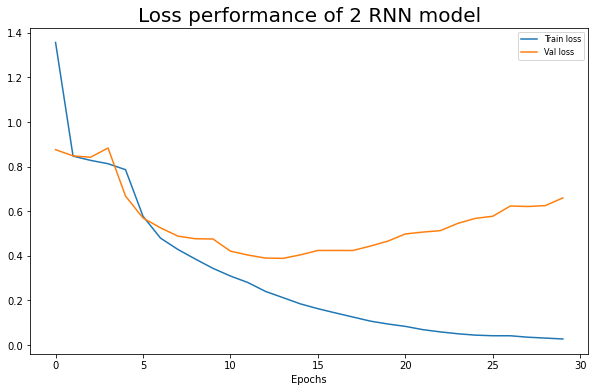

In [ ]:
# Plot the MSE of the model
plt.rcParams["figure.figsize"] = (10,6)
plt.title("Loss performance of 2 RNN model",fontsize=20)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'],  label='Val loss')
plt.legend()
# Set the axes labels
plt.xlabel('Epochs',fontsize=10)
plt.legend(fontsize=8)
plt.show()

In [ ]:
model.evaluate(X_test, y_test, verbose = 1) 

11/11 [==============================] - 1s 82ms/step - loss: 0.6596 - accuracy: 0.8857


[0.6596238613128662, 0.8856816291809082]

In [ ]:
for i in range(10):
  y_pred = model.predict(np.array([X_test[i]]))
  pred = np.argmax(np.array(y_pred), axis=-1)
  print("Original  : ",[*map(idx2word_tag.get, y_test[i])])
  print("predicted : ",[*map(idx2word_tag.get, pred[0])])
  print("-"*100)

Original  :  ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'b-citation', 'i-citation', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o'

In [ ]:
# Model RNN2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense
from keras.layers import SimpleRNN

inputs = Input(shape = (None,))
embeddings = Embedding(input_dim=len_vocab+1, 
                    output_dim=len(tag_list),
                    input_length=300,
                    mask_zero = True,)(inputs)
RNN = SimpleRNN(300,return_sequences=True, recurrent_dropout=0.1, activation="tanh")(embeddings)
RNN = SimpleRNN(300,return_sequences=True, recurrent_dropout=0.1, activation="tanh")(RNN)
output = Dense(len(tag_list),activation='softmax')(RNN)
model2 = Model(inputs = inputs,outputs = output)
model2.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_7 (Embedding)     (None, None, 63)          2882502   
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, None, 300)         109200    
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, None, 300)         180300    
                                                                 
 dense_12 (Dense)            (None, None, 63)          18963     
                                                                 
Total params: 3,190,965
Trainable params: 3,190,965
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
history2 = model2.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=30,batch_size=64)

Epoch 1/30
22/22 [==============================] - 25s 1s/step - loss: 1.1333 - accuracy: 0.7214 - val_loss: 0.7976 - val_accuracy: 0.8037
Epoch 2/30
22/22 [==============================] - 22s 987ms/step - loss: 0.8318 - accuracy: 0.7967 - val_loss: 0.7830 - val_accuracy: 0.8037
Epoch 3/30
22/22 [==============================] - 22s 993ms/step - loss: 0.8231 - accuracy: 0.7967 - val_loss: 0.7820 - val_accuracy: 0.8037
Epoch 4/30
22/22 [==============================] - 22s 1s/step - loss: 0.8246 - accuracy: 0.7958 - val_loss: 0.7799 - val_accuracy: 0.8037
Epoch 5/30
22/22 [==============================] - 22s 987ms/step - loss: 0.8211 - accuracy: 0.7959 - val_loss: 0.7722 - val_accuracy: 0.8037
Epoch 6/30
22/22 [==============================] - 23s 1s/step - loss: 0.8244 - accuracy: 0.7950 - val_loss: 0.7697 - val_accuracy: 0.8038
Epoch 7/30
22/22 [==============================] - 23s 1s/step - loss: 0.8126 - accuracy: 0.7959 - val_loss: 0.7657 - val_accuracy: 0.8037
Epoch 8/30


In [ ]:
model2.save('model2.h5')

In [ ]:
model2 = tf.keras.models.load_model('model2.h5')

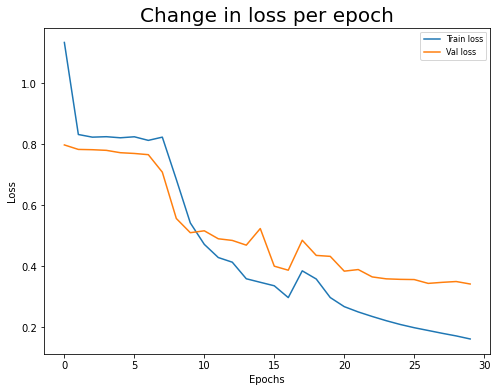

In [ ]:
# Plot the MSE of the model
plt.rcParams["figure.figsize"] = (8,6)
plt.title("Change in loss per epoch",fontsize=20)
plt.plot(history2.history['loss'], label='Train loss')
plt.plot(history2.history['val_loss'],  label='Val loss')
plt.legend()
# Set the axes labels
plt.xlabel('Epochs',fontsize=10)
plt.ylabel('Loss',fontsize=10)
plt.legend(fontsize=8)
plt.show()

In [ ]:
for i in range(10):
  y_pred = model2.predict(np.array([X_test[i]]))
  pred = np.argmax(np.array(y_pred), axis=-1)
  print("Original  : ",[*map(idx2word_tag.get, y_test[i])])
  print("predicted : ",[*map(idx2word_tag.get, pred[0])])
  print("-"*100)

Original  :  ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'b-citation', 'i-citation', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o'

## Let's try a bidirectional LSTM model

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

# Model definition
input = Input(shape=(300,))
model3 = Embedding(input_dim=len_vocab+1, output_dim=len(tag_list), 
                  input_length=300, mask_zero=True)(input)  
model3 = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model3)  
model3 = TimeDistributed(Dense(50, activation="relu"))(model3) 
output = Dense(len(tag_list),activation='softmax')(model3)
model3 = Model(inputs = input,outputs = output)
model3.compile(loss='sparse_categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
model3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 300, 63)           2882502   
                                                                 
 bidirectional_2 (Bidirectio  (None, 300, 100)         45600     
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 300, 50)          5050      
 tributed)                                                       
                                                                 
 dense_7 (Dense)             (None, 300, 63)           3213      
                                                                 
Total params: 2,936,365
Trainable params: 2,936,365
Non-tra

In [ ]:
history3 = model3.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=30,batch_size=64)

Epoch 1/30
22/22 [==============================] - 57s 2s/step - loss: 1.5146 - accuracy: 0.7572 - val_loss: 0.9174 - val_accuracy: 0.7881
Epoch 2/30
22/22 [==============================] - 50s 2s/step - loss: 0.8194 - accuracy: 0.8006 - val_loss: 0.8072 - val_accuracy: 0.7881
Epoch 3/30
22/22 [==============================] - 51s 2s/step - loss: 0.7250 - accuracy: 0.8006 - val_loss: 0.7162 - val_accuracy: 0.7889
Epoch 4/30
22/22 [==============================] - 51s 2s/step - loss: 0.6402 - accuracy: 0.8028 - val_loss: 0.6604 - val_accuracy: 0.7924
Epoch 5/30
22/22 [==============================] - 52s 2s/step - loss: 0.5749 - accuracy: 0.8201 - val_loss: 0.6016 - val_accuracy: 0.8132
Epoch 6/30
22/22 [==============================] - 51s 2s/step - loss: 0.5165 - accuracy: 0.8375 - val_loss: 0.5282 - val_accuracy: 0.8374
Epoch 7/30
22/22 [==============================] - 50s 2s/step - loss: 0.4748 - accuracy: 0.8434 - val_loss: 0.4947 - val_accuracy: 0.8420
Epoch 8/30
22/22 [==

In [ ]:
# Let's save this model with for good, it took 30 minutes to train, while on GPU!!!
model3.save('model3.h5')

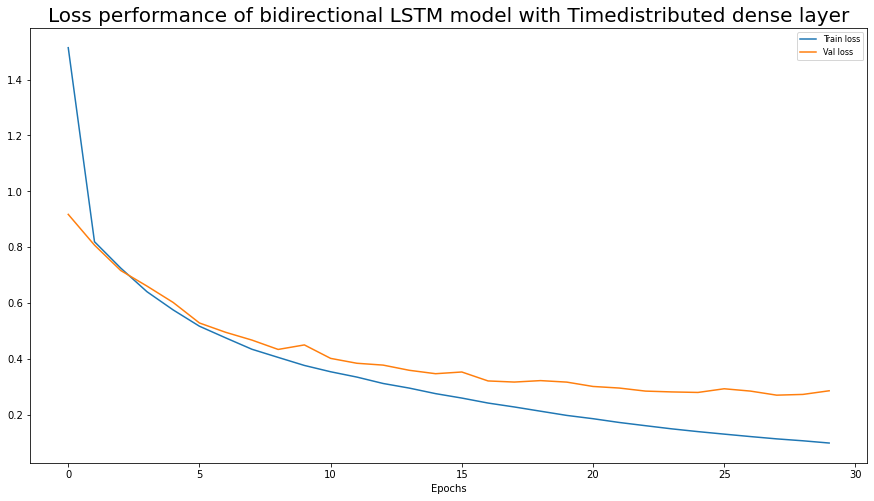

In [ ]:
# Plot the MSE of the model
plt.rcParams["figure.figsize"] = (15,8)
plt.title("Loss performance of bidirectional LSTM model with Timedistributed dense layer",fontsize=20)
plt.plot(history3.history['loss'], label='Train loss')
plt.plot(history3.history['val_loss'],  label='Val loss')
plt.legend()
# Set the axes labels
plt.xlabel('Epochs',fontsize=10)
plt.legend(fontsize=8)
plt.show()

In [ ]:
for i in range(8):
  y_pred = model3.predict(np.array([X_test[i]]))
  pred = np.argmax(np.array(y_pred), axis=-1)
  print("Original  : ",[*map(idx2word_tag.get, y_test[i])])
  print("predicted : ",[*map(idx2word_tag.get, pred[0])])
  print("-"*100)

Original  :  ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'b-citation', 'i-citation', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o'

That looks sweet! isn't it?

# Bonus section (BERT)